# Mermin–Peres 3x3 Magic Square Game

The magic square gives us the observables for each cell is:
                ________________________________
                | +I⊗Z   |  +Z⊗I   |  +Z⊗Z   |
                | +X⊗I   |  +I⊗X   |  +X⊗X   |
                | −X⊗Z   |  −Z⊗X   |  +Y⊗Y   |
                ________________________________
For each diffrent combination of row and coloum selected we will get a diffrent circute.
We measure 2 qbits per player (4 total) and afterward compute with them the 3 bit vector per player (6 bits).

We ran the circute 1024 shots to get all the possiable results and for each we tested if we would have won the game.

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt


class MerminPressSqaure:
    def __init__(self, row, coloum, verbose=False):
        self._row = row
        self._coloum = coloum
        self._alice_qbits = QuantumRegister(2, "alice_q")
        self._bob_qbits = QuantumRegister(2, "bob_q")
        self._alice_cbits = ClassicalRegister(2, "alice_c")
        self._bob_cbits = ClassicalRegister(2, "bob_c")
        self.qc = None
        self._verbose = verbose

    def _log(self, s):
        if self._verbose:
            print(s)

    def _init_circuit(self):
        '''
        Entangle alice and bob qbits to reach the initail state.
        '''
        self.qc = QuantumCircuit(self._alice_qbits, self._bob_qbits, self._alice_cbits, self._bob_cbits)
        self.qc.h(self._alice_qbits[0])
        self.qc.h(self._alice_qbits[1])

        self.qc.cx(self._alice_qbits[0], self._bob_qbits[0])
        self.qc.cx(self._alice_qbits[1], self._bob_qbits[1])

        self.qc.barrier()

    def build_circuit(self):
        '''
        This method preprare it to be measured and measures the players qbits
        '''
        self._prepare_alice()
        self.qc.barrier()
        self._prepare_bob()
        self.qc.barrier()
        self.qc.measure(self._alice_qbits, self._alice_cbits)
        self.qc.measure(self._bob_qbits, self._bob_cbits)

    def _prepare_alice(self):
        '''
        This method places the quantum gate that prepares alice qbits to be measured.
        Row 0:
            The observables are +I⊗Z , +Z⊗I , +Z⊗Z.
            The measurment basis is Z for both qbits.
            We don't need to apply any gates.
        Row 1:
            The observables are +X⊗I , +I⊗X , +X⊗X.
            The measurment basis is X for both qbits.
            We need to apply H gate to both qbits.
        Row 2:
            The observables are −X⊗Z , −Z⊗X , +Y⊗Y.
            The measurment basis is the entangled basis.
            We need to apply the following gates: H(q2)→CX(q2→q1)→H(q2).
        '''

        if self._row == 0:
            pass
        elif self._row == 1:
            self.qc.h(self._alice_qbits[0])
            self.qc.h(self._alice_qbits[1])
        elif self._row == 2:
            self.qc.h(self._alice_qbits[1])
            self.qc.cx(self._alice_qbits[1], self._alice_qbits[0])
            self.qc.h(self._alice_qbits[1])
        else:
            raise ValueError("Wrong row value!")
    
    def _prepare_bob(self):
        '''
        This method places the quantum gate that prepares bob qbits to be measured.
        Row 0:
            The observables are +I⊗Z , +X⊗I , −X⊗Z.
            The measurment basis is Z for q2 and X for q1.
            We need to apply H gate to q1.
        Row 1:
            The observables are +Z⊗I , +I⊗X , −Z⊗X.
            The measurment basis is Z for q1 and X for q2.
            We need to apply H gate to q2.
        Row 2:
            The observables are +Z⊗Z , +X⊗X , +Y⊗Y.
            The measurment basis is the entangled basis.
            We need to apply the following gates: CX(q1→q2)→H(q1).
        '''

        if self._coloum == 0:
            self.qc.h(self._bob_qbits[0])
        elif self._coloum == 1:
            self.qc.h(self._bob_qbits[1])
        elif self._coloum == 2:
            self.qc.cx(self._bob_qbits[0], self._bob_qbits[1])
            self.qc.h(self._bob_qbits[0])
        else:
            raise ValueError("Wrong coloum value!")

    def _measurment_to_result_alice(self, cb1, cb2):
        '''
        This method takes the measurement (2 classical bits - cb1, cb2) and turns them to the vector of the row
        Alice plays.
        Row 0:
            The observables are +I⊗Z , +Z⊗I , +Z⊗Z.
            res = [ cb2, cb1, NOT(cb1 XOR cb2) ]
        Row 1:
            The observables are +X⊗I , +I⊗X , +X⊗X.
            res = [ cb1, cb2, NOT(cb1 XOR cb2) ]
        Row 2:
            The observables are −X⊗Z , −Z⊗X , +Y⊗Y.
            res = [ NOT cb2, NOT cb1, NOT(cb1 XOR cb2) ]
        '''

        if self._row == 0:
            return [cb2, cb1, cb1 * cb2]
        elif self._row == 1:
            return [cb1, cb2, cb1 * cb2]
        elif self._row == 2:
            return [-cb2, -cb1, cb1 * cb2]
        else:
            raise ValueError("Wrong row value!")
    
    def _measurment_to_result_bob(self, cb1, cb2):
        '''
        This method takes the measurement (2 classical bits - cb1, cb2) and turns them to the vector of the coloum
        Bob plays.
        Row 0:
            The observables are +I⊗Z , +X⊗I , −X⊗Z.
            res = [ cb2, cb1, cb1 XOR cb2 ]
        Row 1:
            The observables are +Z⊗I , +I⊗X , −Z⊗X.
            res = [ cb1, cb2, cb1 XOR cb2 ]
        Row 2:
            The observables are +Z⊗Z , +X⊗X , +Y⊗Y.
            res = [ cb2, cb1, cb1 XOR cb2 ]
        '''

        if self._coloum == 0:
            return [cb2, cb1, -(cb1 * cb2)]
        elif self._coloum == 1:
            return [cb1, cb2, -(cb1 * cb2)]
        elif self._coloum == 2:
            return [cb2, cb1, -(cb1 * cb2)]
        else:
            raise ValueError("Wrong coloum value!")

    def _zero_to_minus_one(self, vector):
        '''
        Helper method to switch from {0, 1} base to {-1, 1} base
        '''
        vec = [-1 if x == 1 else 1 for x in vector]
        return vec

    def validate_result(self, alice_row, bob_coloum):
        '''
        This method gets the results and check that alice and bob results statisfy the
        parity check and that the joint element is equal.
        '''
        # Check Alice
        if (alice_row.count(-1) % 2) != 0:
            self._log(f"Game LOST - Alice row parity is incorrect. Alice row is: {alice_row}")
            return False
        # Check Bob
        if (bob_coloum.count(-1) % 2) == 0:
            self._log(f"Game LOST - Bob coloum parity is incorrect. Bob coloum is: {bob_coloum}")
            return False
        # Check joint element
        if alice_row[self._coloum] != bob_coloum[self._row]:
            self._log(f"Game LOST - Joint element mismatch. Alice element: {alice_row[self._coloum]} Bob element: {bob_coloum[self._row]}")
            self._log(f"game details:\nalice:\t{alice_row}\nbob:\t{bob_coloum}")
            return False
        self._log("Game WIN!")
        return True

    def run_simulation(self):
        '''
        Running the simulation and returning the counts.A 
        '''
        simulator = AerSimulator()
        job = simulator.run(self.qc, shots=1024)
        result = job.result()
        plot_histogram(result.get_counts(self.qc))
        return result.get_counts(self.qc)

    def print_circuit(self):
        if self.qc is None:
            self._init_circuit()
            self.build_circuit()
        return self.qc.draw("mpl")
    
    def run_game(self):
        if self.qc is None:
            self._init_circuit()
            self.build_circuit()
        counts = self.run_simulation()
        for measured in counts:
            res = self.play_per_measurment(measured)
            if not res:
                # This case shouldn't happen
                return False
        return True
        
    def play_per_measurment(self, measured):
        measured = measured.replace(" ", "")
        m = [int(char) for char in measured]
        m = self._zero_to_minus_one(m)
        m = m[::-1]
        alice_vec = self._measurment_to_result_alice(m[0], m[1])
        bob_vec = self._measurment_to_result_bob(m[2], m[3])
        return self.validate_result(alice_vec, bob_vec), alice_vec, bob_vec

did_lose = False
for r in range(3):
    for c in range(3):
        game = MerminPressSqaure(r, c)
        did_win = game.run_game()
        fig = game.print_circuit()
        fig.savefig(f"mermin_press_r{r}_c{c}.png")
        if did_win:
            print(f"For (row, coloum) = ({r}, {c}) we got WIN for all outputs")
        else:
            print(f"For (row, coloum) = ({r}, {c}) we got LOSE for at least one input")
            did_lose = True

print("**************************************")
if not did_lose:
    print(f"We WON for all inputs")
else:
    print(f"We LOST for some inputs")
print("**************************************")

For (row, coloum) = (0, 0) we got WIN for all outputs
For (row, coloum) = (0, 1) we got WIN for all outputs
For (row, coloum) = (0, 2) we got WIN for all outputs
For (row, coloum) = (1, 0) we got WIN for all outputs
For (row, coloum) = (1, 1) we got WIN for all outputs
For (row, coloum) = (1, 2) we got WIN for all outputs
For (row, coloum) = (2, 0) we got WIN for all outputs
For (row, coloum) = (2, 1) we got WIN for all outputs
For (row, coloum) = (2, 2) we got WIN for all outputs
**************************************
We WON for all inputs
**************************************


# GHZ (Greenberger–Horne–Zeilinger) pseudo-telepathy

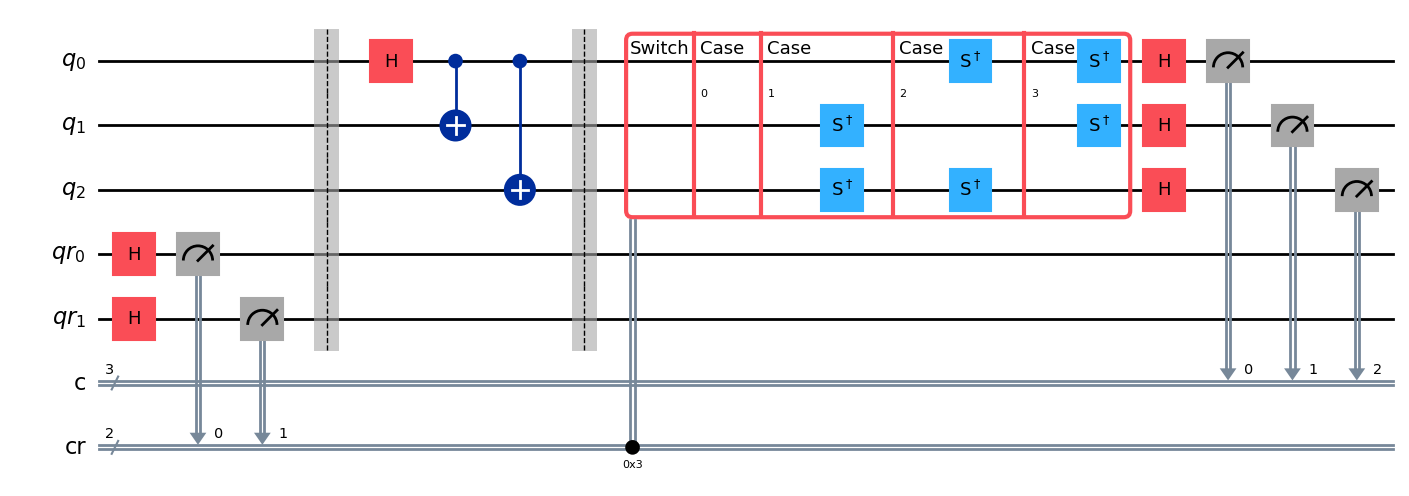

In [2]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt


# Create quantum circuit with 5 qubits and 5 classical bits
qubits = QuantumRegister(3, 'q')
ref_qubits = QuantumRegister(2, 'qr')
clbits = ClassicalRegister(3, 'c')
ref_clbits = ClassicalRegister(2, 'cr')
ghz_circuit = QuantumCircuit(qubits, ref_qubits, clbits, ref_clbits)
(q0, q1, q2) = qubits
(qr0, qr1) = ref_qubits
(c0, c1, c2) = clbits
(cr0, cr1) = ref_clbits

# Setup - Referee draws the binary question - 4 options so 2 bits
ghz_circuit.h(qr0)
ghz_circuit.h(qr1)
ghz_circuit.measure([qr0, qr1], [cr0, cr1])

ghz_circuit.barrier()

# Setup - Entnagle the players qbits
ghz_circuit.h(q0)
ghz_circuit.cx(q0, q1)
ghz_circuit.cx(q0, q2)

ghz_circuit.barrier()

# Expirement
with ghz_circuit.switch(ref_clbits) as case:
    with case(0b00):
        # (0,0,0) - in this case we should return an even result
        pass
    with case(0b01):
        # (0,1,1) - in this case we should return an odd result
        # We want to sample q0 in X base and q1, q2 in Y base
        # We apply S-dagger operation in q1 and q2 to do this.
        ghz_circuit.sdg(q1)
        ghz_circuit.sdg(q2)
    with case(0b10):
        # (1,0,1) - in this case we should return an odd result
        # We want to sample q1 in X base and q0, q2 in Y base
        # We apply S-dagger operation in q0 and q2 to do this.
        ghz_circuit.sdg(q0)
        ghz_circuit.sdg(q2)
    with case(0b11):
        # (1,1,0) - in this case we should return an odd result
        # We want to sample q2 in X base and q0, q1 in Y base
        # We apply S-dagger operation in q0 and q1 to do this.
        ghz_circuit.sdg(q0)
        ghz_circuit.sdg(q1)

ghz_circuit.h(q0)
ghz_circuit.h(q1)
ghz_circuit.h(q2)

ghz_circuit.measure([0, 1, 2], [0, 1, 2])

ghz_circuit.draw("mpl")


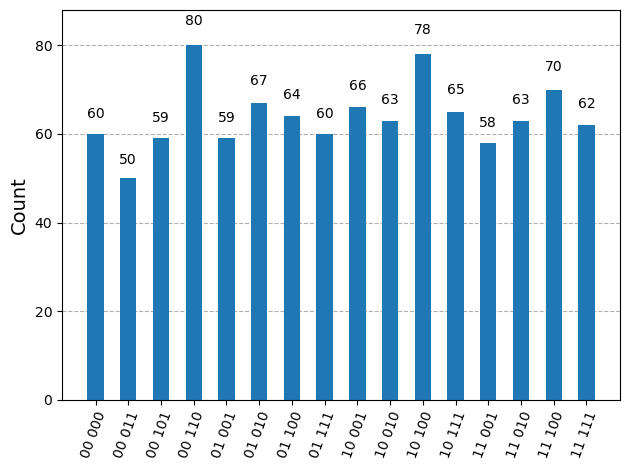

In [3]:
simulator = AerSimulator()
job = simulator.run(ghz_circuit, shots=1024)
result = job.result()
plot_histogram(result.get_counts(ghz_circuit))